### Loading Libraries

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
plt.style.use('bmh')
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split,StratifiedKFold,GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error , r2_score
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_log_error
from sklearn.preprocessing import OneHotEncoder

### Reading the Data

In [3]:
df = pd.read_csv('train.csv')

In [4]:
df.shape

(1460, 81)

In [6]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

## Summary of dataset features
- Total Data Instances : 1460 entries, 0 to 1460 
- Total Data Columns : 81 Columns
- Numerical type Data: 38
- Object type Data:   43

### Plots (Univariate and bivariate analysis) to fetch some from the data

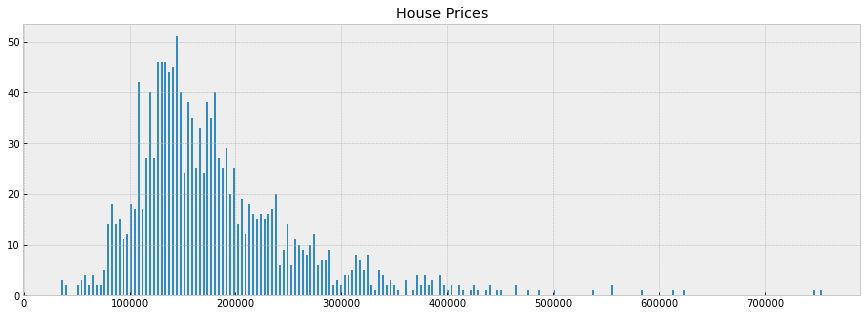

In [16]:
df['SalePrice'].hist(bins=200,rwidth = 0.5, figsize=(15,5))
plt.title('House Prices')
plt.show()

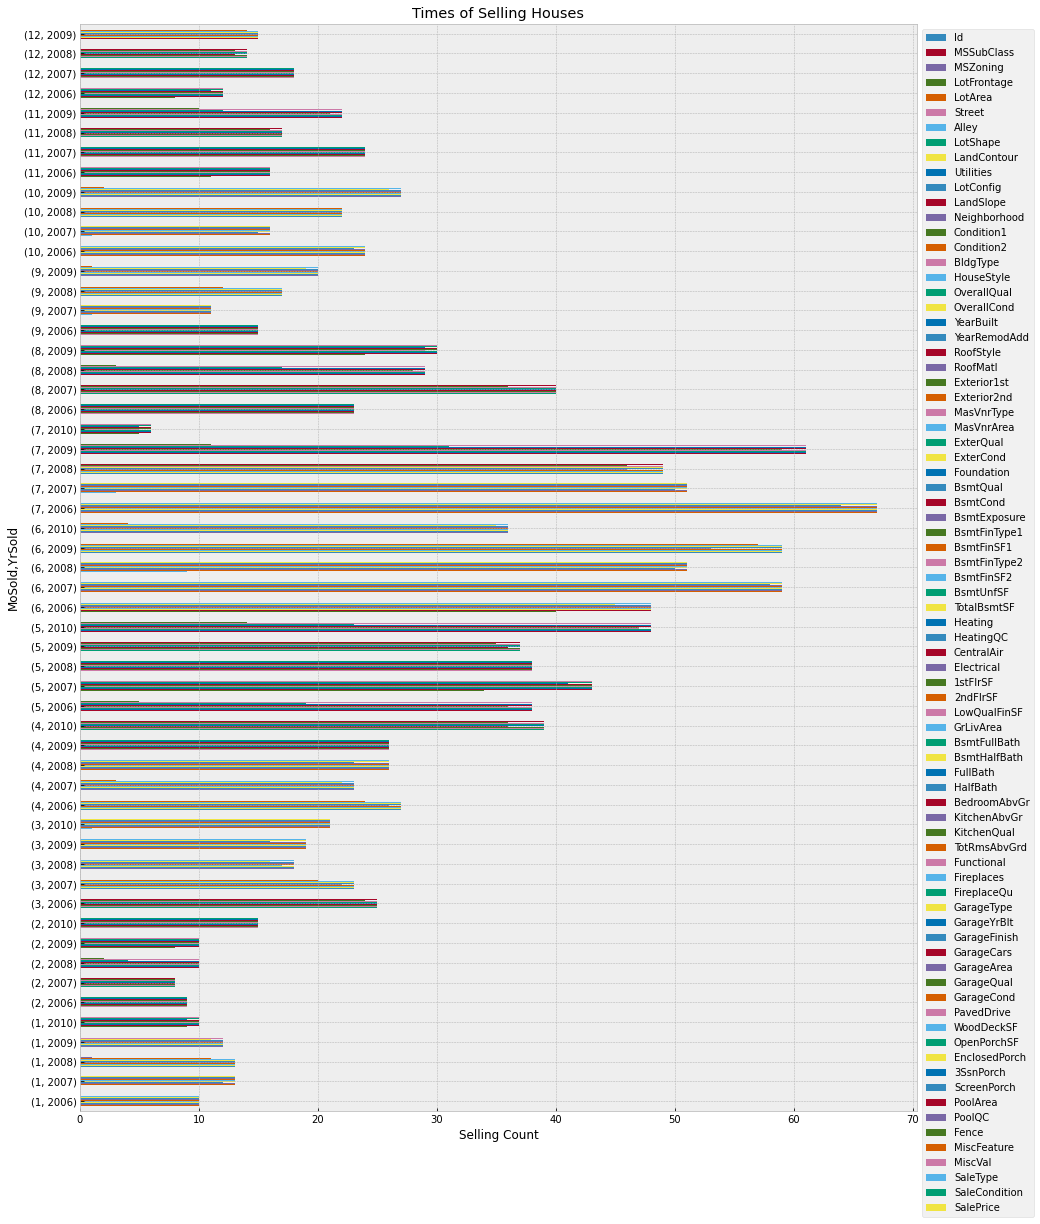

In [18]:
df.groupby(['MoSold','YrSold']).count().plot(kind='barh',figsize=(15,20))
plt.xlabel('Selling Count')
plt.title('Times of Selling Houses')
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

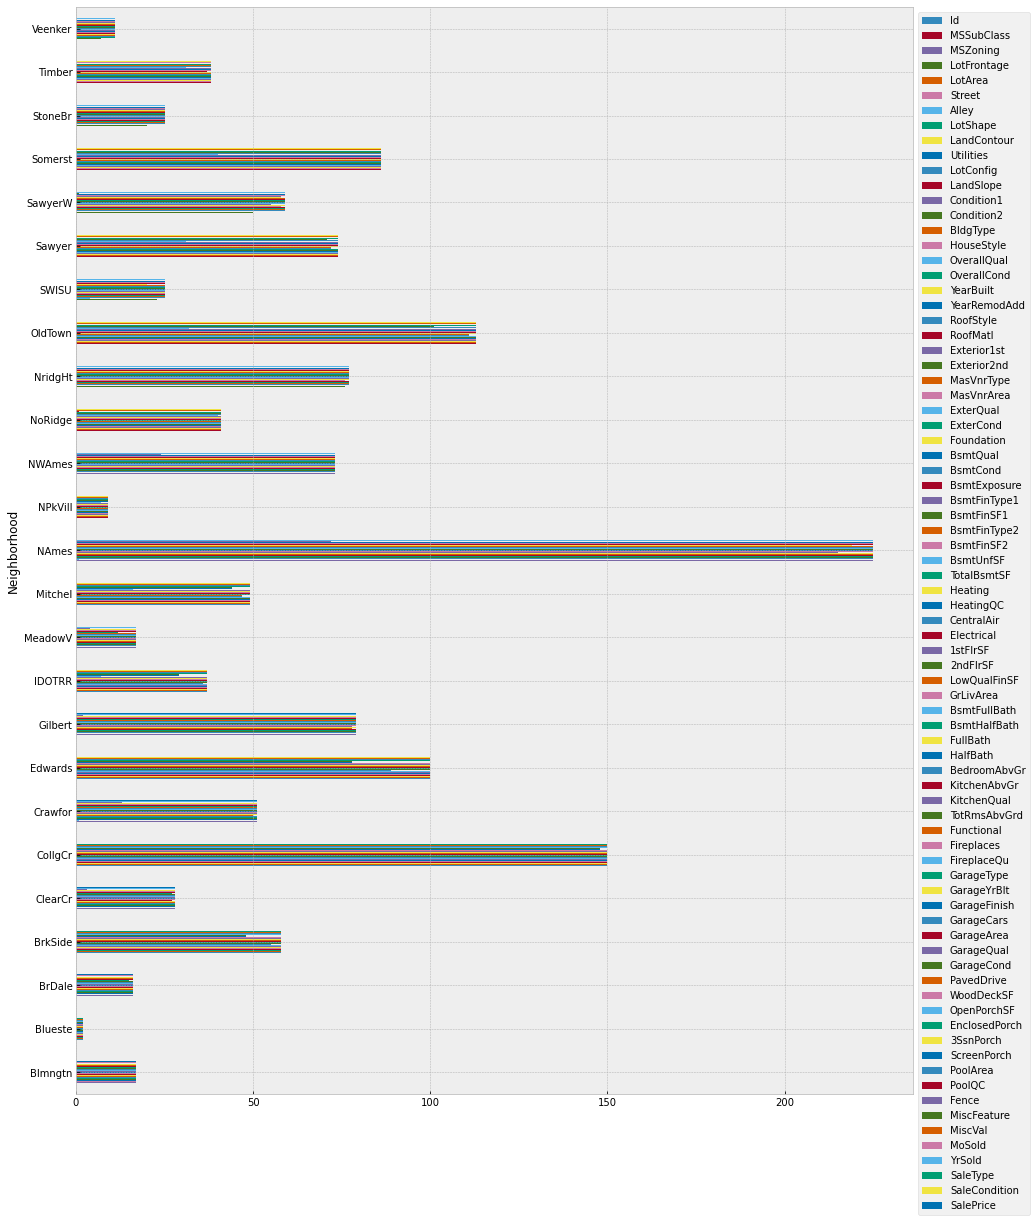

In [19]:
df.groupby(['Neighborhood']).count().plot(kind='barh',figsize=(15,20))
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

<AxesSubplot:>

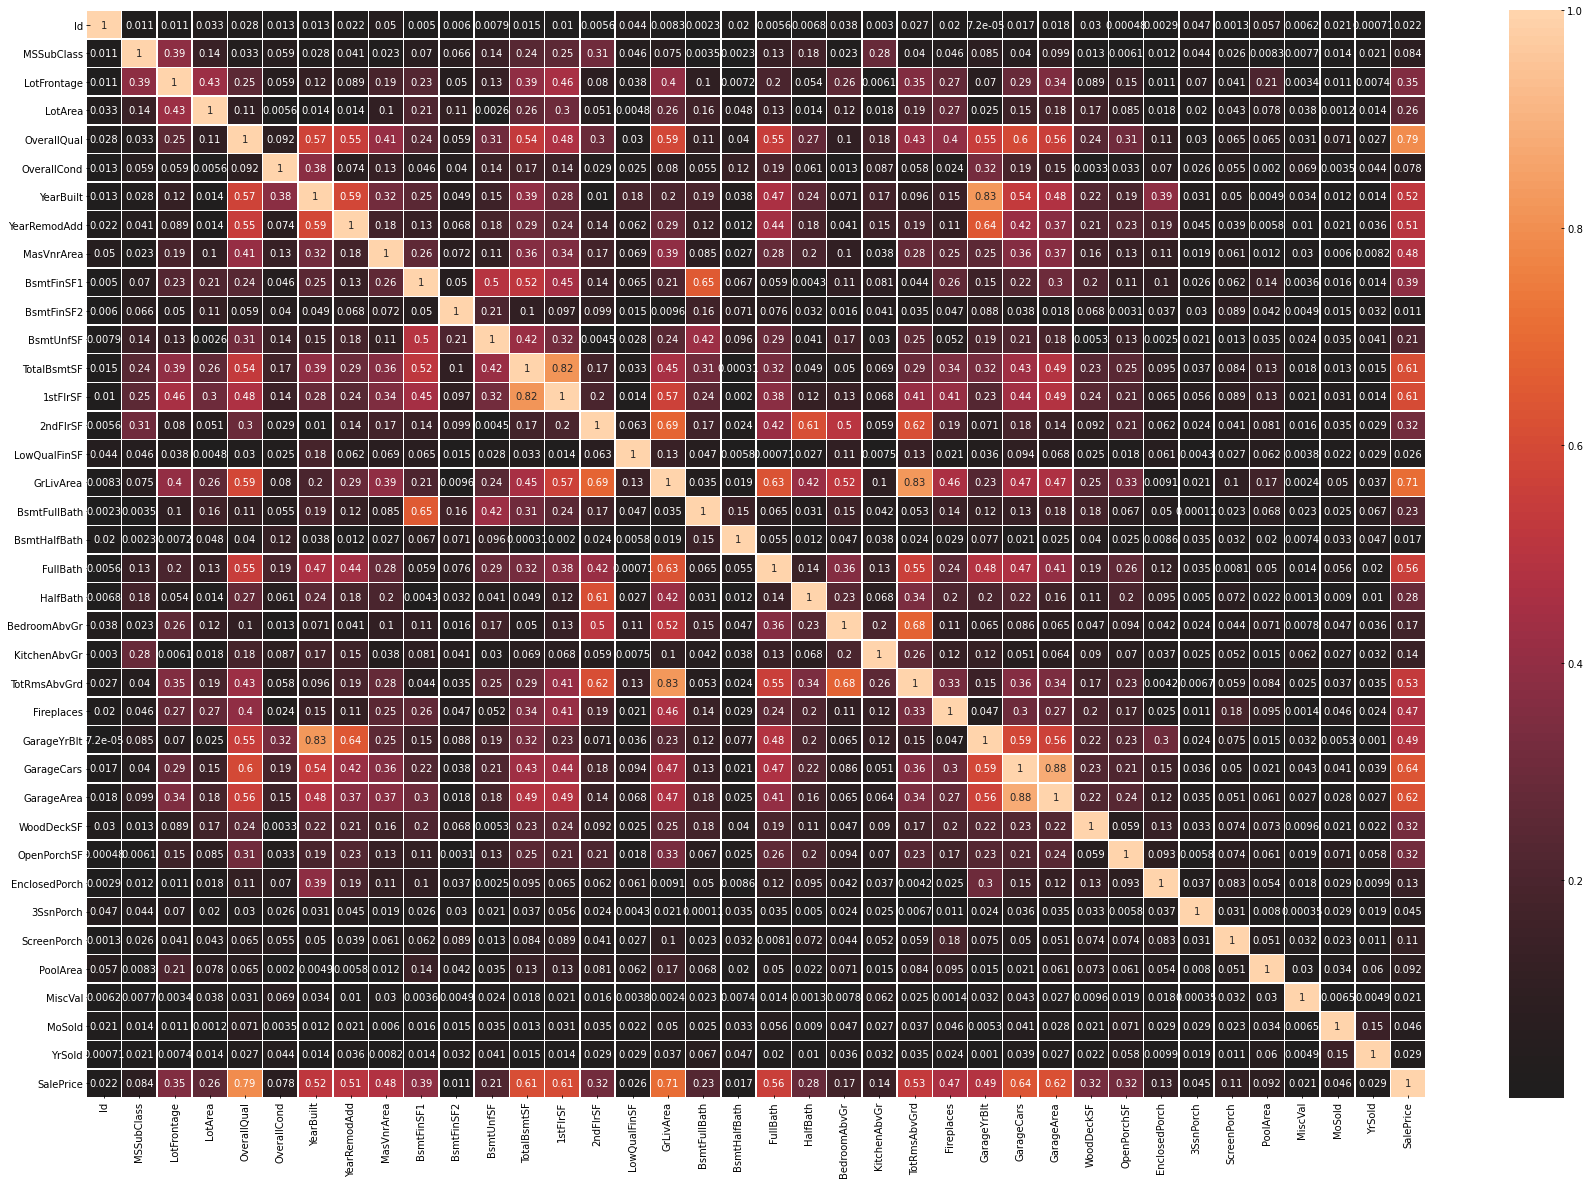

In [24]:
# plotting heatmap for obeserving correlation
fig, ax = plt.subplots(figsize=(30,20))
corr_matrix = df.corr().abs()
sns.heatmap(corr_matrix, annot=True, linewidths=.5, ax=ax,center=0)

### Summary of the plots & Visualiztions
- Majority of houses prices falls in between 100,000 and 250,000
- Also most of the houses were sold in the month of 6 and 7
- Houses with NAmes and collgr were the highest sold

## Pre-Processing the Data

In [25]:
num_features = df.select_dtypes(include=['float', 'int'])
print('Numerical Features Dimension :',num_features.shape)
print(num_features.columns)

Numerical Features Dimension : (1460, 3)
Index(['LotFrontage', 'MasVnrArea', 'GarageYrBlt'], dtype='object')


In [26]:
# check for any missing values
num_feat_null = num_features.isnull().sum().sort_values(ascending = False)
print(num_feat_null)

LotFrontage    259
GarageYrBlt     81
MasVnrArea       8
dtype: int64


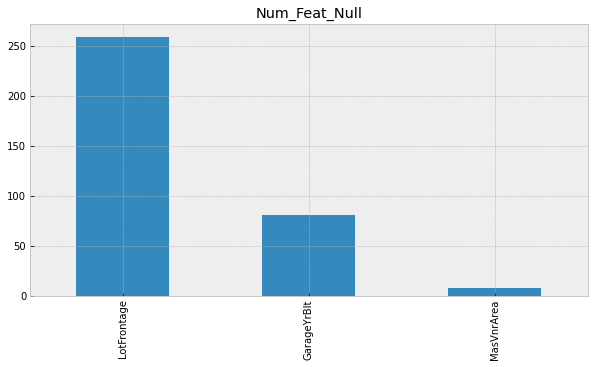

In [27]:
# bar graph for missing_values
plt.figure(figsize=(10,5))
num_feat_null.plot(kind = 'bar')
plt.title('Num_Feat_Null')
plt.show()

In [29]:
object_features = df.select_dtypes(include=['object'])
print('Object Type Features Dimension :',object_features.shape)
print(object_features.columns)

Object Type Features Dimension : (1460, 43)
Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')


In [30]:
# check for any missing values
object_feat_null = object_features.isnull().sum().sort_values(ascending = False)
print(object_feat_null)

PoolQC           1453
MiscFeature      1406
Alley            1369
Fence            1179
FireplaceQu       690
GarageCond         81
GarageQual         81
GarageFinish       81
GarageType         81
BsmtFinType2       38
BsmtExposure       38
BsmtFinType1       37
BsmtQual           37
BsmtCond           37
MasVnrType          8
Electrical          1
Condition2          0
Condition1          0
Neighborhood        0
LandSlope           0
BldgType            0
LandContour         0
LotConfig           0
Utilities           0
RoofStyle           0
LotShape            0
Street              0
HouseStyle          0
SaleCondition       0
RoofMatl            0
Exterior1st         0
Exterior2nd         0
ExterQual           0
ExterCond           0
Foundation          0
SaleType            0
Heating             0
HeatingQC           0
CentralAir          0
KitchenQual         0
Functional          0
PavedDrive          0
MSZoning            0
dtype: int64


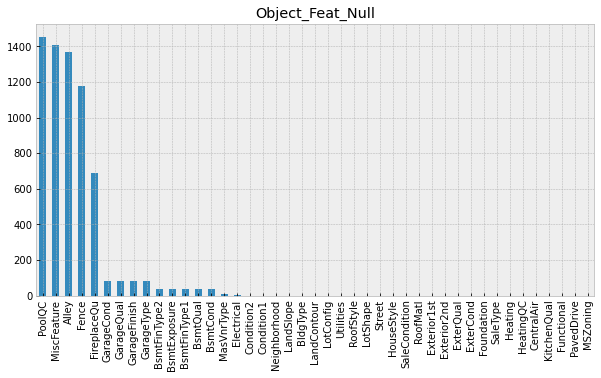

In [31]:
# bar graph for missing_values
plt.figure(figsize=(10,5))
object_feat_null.plot(kind = 'bar')
plt.title('Object_Feat_Null')
plt.show()

In [38]:
null_count=df.isnull().sum()*100/len(df)
miss_house_plot=null_count.sort_values(ascending=False).head(10)
miss_house_plot

PoolQC          99.520548
MiscFeature     96.301370
Alley           93.767123
Fence           80.753425
FireplaceQu     47.260274
LotFrontage     17.739726
GarageCond       5.547945
GarageType       5.547945
GarageYrBlt      5.547945
GarageFinish     5.547945
dtype: float64

In [40]:
drop_columns_list=df.columns[(null_count/100) > .50]
drop_columns_list=list(drop_columns_list)
drop_columns_list

['Alley', 'PoolQC', 'Fence', 'MiscFeature']

- Since the above 4 features has more than 50% missing, I'll be dropping the columns instead of imputation 

In [41]:
df.drop(columns=['Alley', 'PoolQC', 'Fence','MiscFeature'], inplace=True)

In [43]:
house_row_null_count=df.isnull().sum(axis=1)
house_row_null_count.describe()

count    1460.000000
mean        1.067123
std         1.646943
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max        11.000000
dtype: float64

In [49]:
object_feat = df.select_dtypes('object').columns
object_feat

Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition'],
      dtype='object')

In [50]:
for col in object_feat:
    print('{} column has {} unique values'.format(col,df[col].nunique()))

MSZoning column has 5 unique values
Street column has 2 unique values
LotShape column has 4 unique values
LandContour column has 4 unique values
Utilities column has 2 unique values
LotConfig column has 5 unique values
LandSlope column has 3 unique values
Neighborhood column has 25 unique values
Condition1 column has 9 unique values
Condition2 column has 8 unique values
BldgType column has 5 unique values
HouseStyle column has 8 unique values
RoofStyle column has 6 unique values
RoofMatl column has 8 unique values
Exterior1st column has 15 unique values
Exterior2nd column has 16 unique values
MasVnrType column has 4 unique values
ExterQual column has 4 unique values
ExterCond column has 5 unique values
Foundation column has 6 unique values
BsmtQual column has 4 unique values
BsmtCond column has 4 unique values
BsmtExposure column has 4 unique values
BsmtFinType1 column has 6 unique values
BsmtFinType2 column has 6 unique values
Heating column has 6 unique values
HeatingQC column has 5 

In [51]:
print(df['Utilities'].unique())
print(df['CentralAir'].unique())
print(df['LandSlope'].unique())
print(df['ExterQual'].unique())
print(df['ExterCond'].unique())
print(df['BsmtQual'].unique())
print(df['BsmtCond'].unique())
print(df['BsmtExposure'].unique())
print(df['BsmtFinType1'].unique())
print(df['BsmtFinType2'].unique())
print(df['HeatingQC'].unique())
print(df['KitchenQual'].unique())
print(df['FireplaceQu'].unique())
print(df['GarageQual'].unique())
print(df['GarageCond'].unique())

['AllPub' 'NoSeWa']
['Y' 'N']
['Gtl' 'Mod' 'Sev']
['Gd' 'TA' 'Ex' 'Fa']
['TA' 'Gd' 'Fa' 'Po' 'Ex']
['Gd' 'TA' 'Ex' nan 'Fa']
['TA' 'Gd' nan 'Fa' 'Po']
['No' 'Gd' 'Mn' 'Av' nan]
['GLQ' 'ALQ' 'Unf' 'Rec' 'BLQ' nan 'LwQ']
['Unf' 'BLQ' nan 'ALQ' 'Rec' 'LwQ' 'GLQ']
['Ex' 'Gd' 'TA' 'Fa' 'Po']
['Gd' 'TA' 'Ex' 'Fa']
[nan 'TA' 'Gd' 'Fa' 'Ex' 'Po']
['TA' 'Fa' 'Gd' nan 'Ex' 'Po']
['TA' 'Fa' nan 'Gd' 'Po' 'Ex']


In [53]:
df['Utilities'] = df.Utilities.map({'AllPub':1,'NoSeWa':0})
df['CentralAir'] = df.CentralAir.map({'Y':1,'N':0})
df['LandSlope'] = df.LandSlope.map({'Gtl':0,'Mod':1,'Sev':3})
df['ExterQual'] = df.ExterQual.map({'Gd':2,'TA':1,'Ex':3,'Fa':0})
df['ExterCond'] = df.ExterCond.map({'Gd':3,'TA':2,'Ex':4,'Fa':1,'Po':0})
df['BsmtQual'] = df.BsmtQual.map({'Fa':1,'TA':2,'Gd':3,'Ex':4})
df['BsmtCond'] = df.BsmtCond.map({'Po':1,'Fa':2,'TA':3,'Gd':4})
df['BsmtExposure'] = df.BsmtExposure.map({'No':1,'Mn':2,'Av':3,'Gd':4})
df['BsmtFinType1'] = df.BsmtFinType1.map({'Unf':1,'LwQ':2,'Rec':3,'BLQ':4,'ALQ':5,'GLQ':6})
df['BsmtFinType2'] = df.BsmtFinType2.map({'Unf':1,'LwQ':2,'Rec':3,'BLQ':4,'ALQ':5,'GLQ':6})
df['HeatingQC'] = df.HeatingQC.map({'Gd':3,'TA':2,'Ex':4,'Fa':1,'Po':0})
df['KitchenQual'] = df.KitchenQual.map({'Gd':2,'TA':1,'Ex':3,'Fa':0})
df['FireplaceQu'] = df.FireplaceQu.map({'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5})
df['GarageQual'] = df.GarageQual.map({'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5})
df['GarageCond'] = df.GarageCond.map({'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5})

In [54]:
df['BsmtQual'].fillna(0, inplace=True)
df['BsmtCond'].fillna(0, inplace=True)
df['BsmtExposure'].fillna(0, inplace=True)
df['BsmtFinType1'].fillna(0, inplace=True)
df['BsmtFinType2'].fillna(0, inplace=True)
df['FireplaceQu'].fillna(0, inplace=True)
df['GarageQual'].fillna(0, inplace=True)
df['GarageCond'].fillna(0, inplace=True)

In [55]:
print(df.shape)

(1460, 77)


In [57]:
obj_cols=df.select_dtypes('object').columns
obj_cols

Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'LotConfig',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'Foundation', 'Heating', 'Electrical', 'Functional', 'GarageType',
       'GarageFinish', 'PavedDrive', 'SaleType', 'SaleCondition'],
      dtype='object')

### Encoding the non ordinal features

In [58]:
df=pd.get_dummies(df,columns=obj_cols)

In [59]:
print(df.shape)

(1460, 228)


### Checking missing values in the remaining features

In [60]:
missing_val_count_by_column = (df.isnull().sum())
print(missing_val_count_by_column[missing_val_count_by_column > 0])

LotFrontage    259
MasVnrArea       8
GarageYrBlt     81
dtype: int64


In [61]:
df['LotFrontage']=df['LotFrontage'].fillna(df['LotFrontage'].median())
df['MasVnrArea']=df['MasVnrArea'].fillna(df['MasVnrArea'].median())
df['GarageYrBlt']=df['GarageYrBlt'].fillna(df['GarageYrBlt'].median())

**lets split the data as X (dependent features) and y (independent feature)**

In [64]:
X=df.drop(['SalePrice'],axis=1)
y=df['SalePrice']

In [65]:
X.shape, y.shape

((1460, 227), (1460,))

In [66]:
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.20, random_state=42,shuffle=True)

In [72]:
lr=LinearRegression()
dt=DecisionTreeRegressor()
rf=RandomForestRegressor()
svm=SVR()
adab=AdaBoostRegressor()
clf_list=[lr, dt,rf,svm,adab]
for model in clf_list:
        grid = GridSearchCV(estimator=model, param_grid={}, scoring='neg_root_mean_squared_error', cv=3, n_jobs=-1,verbose=3)
        grid.fit(X, y)
        print(model, '\n', -grid.best_score_,'\n',grid.best_estimator_)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   17.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


LinearRegression() 
 33990.17492282006 
 LinearRegression()
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


DecisionTreeRegressor() 
 41689.82650968439 
 DecisionTreeRegressor()
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.4s finished


RandomForestRegressor() 
 29952.923545609174 
 RandomForestRegressor()
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.7s finished


SVR() 
 81503.30310148832 
 SVR()
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.0s finished


AdaBoostRegressor() 
 36124.63285481095 
 AdaBoostRegressor()


In [74]:
final_model=RandomForestRegressor()
final_model.fit(X,y)
final_predict=final_model.predict(X_test)
predictions = pd.DataFrame({'Id': X_test.index,'SalePrice': final_predict})
predictions

,Id,SalePrice
0,892,150269.75
1,1105,318477.26
2,413,117061.50
3,522,155753.50
4,1036,317580.11
...,...,...
287,479,100180.41
288,1361,254397.15
289,802,183936.86
290,651,119130.87


In [75]:
predictions.to_csv('predictions.csv', index=False)